In [145]:
'''
Objects and classes of celestial objects are loaded from files. 

    objectlist and cometlist attributes:
        Name (str):       Name of the object
        Mass (float):     Mass of the object in kilograms
        Distance (list):  x and y coordinates of the object in meters. 
                          It is calculated as distance to the zeroth object (not the center of mass).
        Velocity (list):  x and y velocities in meters/second
        Track (list):     Record of trajectory of the object in shape (:,2)
        color (str):      Color of the object in animation
        size (int):       Size of the object in animation
        radius (float):   Radius of the object in meters.
        
    Variables:
        Au (float):       Distance from Sun to Earth in meters. 1 Au = 1 Astronomical unit = 1e11 m.
'''

print("Choose simulation from list (1-5):")
print("1: Solar system planets' simulation with few comets")
print("2: Stellar birth zone simulation")
print("3: Cataclystic event")
print("4: Brown dwarf passing Solar system close by")
print("5: Super massive black hole at center, A lot of stars around")
print("6: Brown dwarf passing comet-rich Kuyper belt")
print("7: Comets are Jupiters!")

input1 = input("Choose simulation!")
if input1 == str(1):
    %run simulations/simu_solarsystem.py
elif input1 == str(2):
    %run simulations/simu_stars.py    
elif input1 == str(3):
    %run simulations/simu_cataclysm.py
elif input1 == str(4):
    %run simulations/simu_solarsystem_bd.py
elif input1 == str(5):
    %run simulations/simu_smbh.py
elif input1 == str(6):
    %run simulations/simu_solarsystem_bd2.py
elif input1 == str(7):
    %run simulations/simu_jupiters.py
    input1 = str(1)

else:
    print("No valid simulation chosen.")
    print("Choosing template simulation.")
    %run simu_0.py   

Choose simulation from list (1-5):
1: Solar system planets' simulation with few comets
2: Stellar birth zone simulation
3: Cataclystic event
4: Brown dwarf passing Solar system close by
5: Super massive black hole at center, A lot of stars around
6: Brown dwarf passing comet-rich Kuyper belt
7: Comets are Jupiters!
Choose simulation!1
Simulation: Solar system planets and few comets
+---------+-------+------------+------------+--------+------------+------------+
|  Object |  Mass | Distance x | Distance y | Radius | Velocity x | Velocity y |
+---------+-------+------------+------------+--------+------------+------------+
|   Sun   | 2e+30 |   0e+00    |   0e+00    | 7e+08  |   0e+00    |   0e+00    |
| Mercury | 3e+23 |   7e+10    |   0e+00    | 2e+06  |   0e+00    |   5e+04    |
|  Venus  | 5e+24 |   1e+11    |   0e+00    | 6e+06  |   0e+00    |   3e+04    |
|  Earth  | 6e+24 |   2e+11    |   0e+00    | 6e+06  |   0e+00    |   3e+04    |
|   Mars  | 6e+23 |   2e+11    |   0e+00    | 3e

In [146]:
#### import numpy as np
import copy
import scipy
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
from ipywidgets import IntProgress
matplotlib.rcParams['animation.embed_limit'] = 2**128

'''
    SIMULATION:
        
    Routine map: simulation ---> move ----> update --------------->
                                ^    .         .                   |
                                |    .movement . collision check   |
                                |    .         .                   |
                                |    .velocity .                   |
                                |    .         .                   |
                                |    .Gravity  .                   |
                                |    .         .                   |
                                |    .distance .                   |
                                <----------------------------------save
                
                
    Common and global variables through simulation:
                l_obj       (list)     List of objects
                lcon        (list)     List of constants
                lastx,lasty (list)     List of last coordinates before collision
                ctime,ci    (list)     Record of collision time and index in track
                Gra         (float)    Newtons constant of gravity
                M           (float)    Total mass of the system in kilograms
                
    Progress variables
                dt           (float)    Time step of simulation (one day in seconds). 
                f,f2         (int)      Progress bar variables
                simulength   (float)    Length of simulation in years
                anilength    (float)    Length of animation in days
                count,count2 (float)    Progress bar variables
    
    
    Subroutines:
    --------------------------------------------------------------------------------------------------
                dist(l_obj,i,j,k,):
                
                    Description:               Calculates two objects' distance, from list of objects
                    Arguments: 
                            i,j         (int)      The indices of l_obj to be calculated
                            k           (int)      Index of coordinate (x=0, y=1)
                    Returns:
                                        (Float)    Distance of objects in chosen coordinate.
                    ----------------------------------------------------------------------------------
                distance_sq(l_obj,i,j):

                    Description:               Raises the sum of obtained distances to power 1.5
                    Arguments: 
                            i,j         (int)      The indices of l_obj to be calculated
                    Returns:
                                        (Float)    True distance cubed
                    ----------------------------------------------------------------------------------
                gravity(l_obj,l_con):

                    Description:                   Calculates gravity between all objects
                    Variables:
                            k,p         (int)      The indices of l_obj to be calculated
                            l_Gx,l_Gy   (array)    Temporary arrays to calculate gravity between 2 objects
                            Gtotx,Gtoty (array)    Total gravities
                    Returns:
                                        (array)    Total gravity in x and y direction
                    ----------------------------------------------------------------------------------
                com(l_obj,l_con):

                    Description:                   Calculates systems center of mass
                    Variables:
                            i           (int)      The index of l_obj to be calculated
                            tempx,tempy (float)    Temporary variables to store weights
                            x0,y0       (float)    Coordinates of center of mass    
                    Returns:
                                        (float)    x0,y0
                    ----------------------------------------------------------------------------------
                move(l_obj,l_con,dt):

                    Description:                   Moves the objects for time step dt
                    Arguments:
                            dt          (float)    Time step of simulation
                    Variables:
                            i           (int)      The index of l_obj to be calculated
                            GS          (array)    Gravity obtained from gravity()
                            velox,veloy (float)    Added velocity after dt
                            px,py       (float)    Travelled distance in x- and y-direction
                    Returns:
                                        (float)    px,py
                    ----------------------------------------------------------------------------------
                update(l_obj,l_con,time):

                    Description:                   Updates the state of objects
                    Arguments:
                            dt          (float)    Time step of simulation
                    Variables:
                            i           (int)      The index of l_obj to be calculated
                            GS          (array)    Gravity obtained from gravity()
                            velox,veloy (float)    Added velocity after dt
                            px,py       (float)    Travelled distance in x- and y-direction
                            check       (bool)     Returned value if two object collide or not.
                            index       (int)      Returned value of lighter object that collided

                    
                    Returns:
                                        (float)    px,py
                    ----------------------------------------------------------------------------------
                collision_check(l_obj):

                    Description:                   Calculates systems center of mass
                    Arguments:
                            dt          (float)    Time step of simulation
                    Variables:
                            i           (int)      The index of l_obj to be calculated
                            GS          (array)    Gravity obtained from gravity()
                            velox,veloy (float)    Added velocity after dt
                            px,py       (float)    Travelled distance in x- and y-direction
                            check       (bool)     Returned value if two object collide or not.
                            index       (int)      Returned value of lighter object that collided

                    
                    Returns:
                                        (float)    px,py
                    ----------------------------------------------------------------------------------
'''

input_l = input("How long simulation in years?")
simulength = float(input_l)
print(simulength)

#--------Define the center of mass--------
CM = objectlist()
CM.name = "Center of mass"
CM.distance = [0,0]
CM.velocity = [0,0]
CM.track = copy.deepcopy(CM.distance)
CM.color = "darkgrey"
CM.size = 5
CM.radius = 1
#------------------------------------------
print("Simulation Progress")
print("..................")

lastx=[]
lasty=[]
ctime,ci = [],[]
i=0
#return track length to zero from possible previous simulations, also set previous starting point.
while i<len(l_obj):
    l_obj[i].track = copy.deepcopy(l_obj[i].distance)
    i=i+1
#-----------------------------------------------------
#---------List of constants and variables in program----------------------
year = 24*60*60*365
simulength = simulength*year
Gra    = 6.67e-11
M=0
dt=24*60*60*1 #one day cycle
for i in range(len(l_obj)):
    M = M + l_obj[i].mass
CM.mass = M
l_con = [Gra,Au,year,M]
max_count = int(simulength/dt)
f2 = IntProgress(min=0, max=max_count,description="Loading",bar_style='success') # instantiate the bar
display(f2) # display the bar
count2 = 0
#------------------------------------------------------------Subroutines
def dist(l_obj,i,j,k):
    return (l_obj[i].distance[k] - l_obj[j].distance[k])
    
def distance_sq(l_obj,i,j):
    x = dist(l_obj,i,j,0)
    y = dist(l_obj,i,j,1)
    return (x**2 + y**2)**1.5
def gravity(l_obj,l_con):
    k=0
    p=0
    G_totx=[]
    G_toty=[]
    while k<len(l_obj):
        l_Gx=[]
        l_Gy=[]
        while p<len(l_obj):
            if p==k:
                p=p+1
                if p>=len(l_obj):
                    break
            if l_obj[k].distance[0]<30000*Au and l_obj[k].distance[1]<30000*Au:
                l_Gx = np.append(l_Gx, -Gra*dist(l_obj,k,p,0)*(l_obj[k].mass*l_obj[p].mass)/(distance_sq(l_obj,k,p)))
                l_Gy = np.append(l_Gy, -Gra*dist(l_obj,k,p,1)*(l_obj[k].mass*l_obj[p].mass)/(distance_sq(l_obj,k,p)))
            else:
                l_Gx = np.append(l_Gx,0)
                l_Gy = np.append(l_Gy,0)
            p=p+1
        G_totx = np.append(G_totx, np.sum(l_Gx))
        G_toty = np.append(G_toty, np.sum(l_Gy))
        k=k+1
        p=0
    return G_totx,G_toty

def com(l_obj,l_con): #Center of mass distance to the sun
    i=0
    tempx=0
    tempy=0
    while i<len(l_obj): #Vapausasteista riippumaton lasku
        tempx = tempx + (l_obj[i].mass*l_obj[i].distance[0])
        tempy = tempy + (l_obj[i].mass*l_obj[i].distance[1])
        i=i+1
    x0 = tempx / CM.mass
    y0 = tempy / CM.mass
    return x0,y0
#----------------------
def move(l_obj,l_con,dt): #Move the objects dt
    #Count new velocity, move the object, update position
    GS = gravity(l_obj,l_con)
    px = []
    py = []
    i=0
    while i<len(l_obj):
        velox = l_obj[i].velocity[0] + (GS[0][i]*dt/l_obj[i].mass)
        veloy = l_obj[i].velocity[1] + (GS[1][i]*dt/l_obj[i].mass)
        px = np.append(px,velox*dt) #Travelled distance
        py = np.append(py,veloy*dt)
        l_obj[i].velocity[0],l_obj[i].velocity[1] = velox,veloy       
        
        i=i+1
    #print(px,py)
    return px,py
def simulate(a):

    return 

def update(l_obj,pos,time):
    global ctime,ci,lastx,lasty
    i=0
    while i<len(l_obj):
        l_obj[i].distance[0] = l_obj[i].distance[0] + pos[0][i]
        l_obj[i].distance[1] = l_obj[i].distance[1] + pos[1][i]
        CM.distance = com(l_obj,l_con)
        l_obj[i].track = np.vstack((l_obj[i].track,[l_obj[i].distance[0],l_obj[i].distance[1]]))
        CM.track = np.vstack((CM.track,[CM.distance[0],CM.distance[1]]))
        check,index = collision_check(l_obj)
        if check:
            if len(ci)==0:
                ctime = np.append(ctime,time)
                ci = np.append(ci,index)                
                lastx = np.append(lastx,copy.deepcopy(l_obj[index].track[-1,0]))
                lasty = np.append(lasty,copy.deepcopy(l_obj[index].track[-1,1]))            
            elif len(ci)!=0 and int(ci[-1])!=int(index): 
                ctime = np.append(ctime,time)
                ci = np.append(ci,index)
                lastx = np.append(lastx,copy.deepcopy(l_obj[index].track[-1,0]))
                lasty = np.append(lasty,copy.deepcopy(l_obj[index].track[-1,1]))
        i=i+1
    return 


def calculate_perimeter(a,b):
    perimeter = math.pi * ( 3*(a+b) - math.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter #Not used currently in this simulation

def collision_check(l_obj):
    i=0
    j=0
    exit = False
    while i<len(l_obj):
        while j<len(l_obj):
            if i==j:
                j=j+1
                if j>=len(l_obj):
                    break
            if (abs(l_obj[i].distance[0]-l_obj[j].distance[0])<10*(l_obj[i].radius+l_obj[j].radius)
               and abs(l_obj[i].distance[1]-l_obj[j].distance[1])<10*(l_obj[i].radius+l_obj[j].radius)):

                #Get the larger value!
                new_mass = l_obj[i].mass + l_obj[j].mass
                new_velox = (l_obj[i].velocity[0]*l_obj[i].mass + l_obj[j].velocity[0]*l_obj[j].mass)/new_mass
                new_veloy = (l_obj[i].velocity[1]*l_obj[i].mass + l_obj[j].velocity[1]*l_obj[j].mass)/new_mass
                t = max(l_obj[i].mass,l_obj[j].mass)
                s = min(l_obj[i].mass,l_obj[j].mass)
                kr=0
                while kr<len(l_obj):
                    if l_obj[kr].mass == t:
                        l_obj[kr].mass = new_mass
                        l_obj[kr].velocity = [new_velox,new_veloy]
                        tr=0
                        while tr<len(l_obj):
                            if l_obj[tr].mass==s:
                                l_obj[tr].mass = 1
                                exit=True
                                return exit,tr
                            tr=tr+1
                    if exit:
                        break
                    kr=kr+1
            j=j+1

        i=i+1
        j=0
    return False,False

#---------------Simulation!--------------------
i=0
print("Progress")
while i<simulength:
    time = int(i/dt)
    simulate(update(l_obj,move(l_obj,l_con,dt),time))
    f2.value += 1 # signal to increment the progress bar
    count2   += 1 # signal to increment the progress bar
    if i%10000000 == 0:
        print(round(100*i/simulength),"%")
    i=i+dt
anilength=int(i/dt)
#----------End of simulation-------------------
#----------Clean the collisions arrays---------
i=1
while i<len(ctime):
    if ctime[i-1]==ctime[i] or ctime[i-1]==ctime[i]+1:
        ctime = np.delete(ctime,i)
        ci = np.delete(ci,i)
        lastx = np.delete(lastx,i)
        i=i-1
    i=i+1
try:
    ctime=ctime.astype(int)
    ci = ci.astype(int)
except:
    ctime=[0]
    ci = [0]
i=0
while i<len(ci) and len(lastx)!=0:
    l_obj[ci[i]].track[ctime[i]+1:,0] = lastx[i]
    l_obj[ci[i]].track[ctime[i]+1:,1] = lasty[i]
    i=i+1
#-----------------------------------------------

print("data ready")
print("datapoints: ", len(l_obj[0].track[:,0]))


i=0

#------reshape data for animation!------------
#------Take every tenth value from array:-----
i=1
j=0
while j<len(l_obj):
    l_obj[j].track = l_obj[j].track[9::10,:]    
    j=j+1
anilength = len(l_obj[0].track)

print("Datapoints for animation", anilength)

How long simulation in years?1
1.0
Simulation Progress
..................


IntProgress(value=0, bar_style='success', description='Loading', max=365)

Progress
0 %
data ready
datapoints:  366
Datapoints for animation 36


In [134]:

'''
    Animation setup sequences

        In this cell, there are setup subroutines that are called from the cell below.


    Animation routine:
    
                animate ---> zerosettings ---> update ------>
                                                ^           .
                                                .           .
                                                .increment  .
                                                .zoomer     .
                                                <------------save

 
               Common variables and constants used:
                            
                            input1      (str)      Name of the simulation (1-7)
                            scal        (float)    Scaling parameter of the current width of grid
                            ax,ax2      (obj)      Plotting object
                            myvars      (dict)     Library file of animation objects. In myvars there 
                                                   are 3 different names: "line","point","text".
                                                   Each key has an index, depending on simulation.
                                                   For example, "myvars[text0]" refers to object list
                                                   index 0 (The Sun). Line is the 2d line object, point
                                                   is the point object to be drawn and text is a text
                                                   object.
                            f,count     (int)      Progress bar variables
                            timer       (obj)      Timer object of animation
    
    

    Subroutines:
    --------------------------------------------------------------------------------------------------
                zoomer(input1,i,Au,scal,ax):
                
                    Description:                   Zooms in or out of the center, depending on simulation
                                                   and simulation time
                    Returns:
                                    (bool),(float) boolean value whether to continue the sequence,
                                                   scaling parameters new value.
                --------------------------------------------------------------------------------------
                increment(r,i):
                    
                    Description:                  Animates the objects depending if they are collapsed
                                                  or not. If collapsed, the point and text is set
                                                  outside the grid and the line is no longer drawn.
                    
                    Arguments:
                                i,r       (int)   Index variables
                                
                    Returns:                      None
                --------------------------------------------------------------------------------------
                update(i):
                    
                    Description:                  Animation program. Updates the values and calls other
                                                  subroutines. 
                    
                    Arguments:
                                i         (int)   Index of animation. Maximum is anilength, min  is 0. 
                                
                    Returns:    myvars    (dict)  Returns myvars-text,point and line objects for animation.
                --------------------------------------------------------------------------------------
                zerosettings(input1,ax):
                    
                    Description:                  Defines the starting settings of animation. Depends
                                                  on simulation number.
                    
                                
                    Returns:    scal      (float) Scaling parameter

'''


def zoomer(input1, i, Au,scal,ax):
    if input1 == "1": #Planets and comets
        if i>=700 and i<=900 and scal>8*Au: #Zoom into the system
        
            rescale=True
            ax.axis('equal')
            ax.set_xlim(-scal,scal)
            ax.set_ylim(-scal,scal)
            timer.set_position((-scal,scal))
            scal=scal*0.99
            if scal<=20*Au:
                default_x_ticks = np.linspace(-8*Au,8*Au,5)
                plt.xticks(default_x_ticks, [-8,-4,0,4,8])
                default_y_ticks = np.linspace(-8*Au,8*Au,5)
                plt.yticks(default_y_ticks, [-8,-4,0,4,8])
            return True,scal
        
        
        else:
            rescale =False
        if i>=200 and i<=300 and scal<=45*Au and not rescale: #Zoom out first time
            ax.axis('equal')
            ax.set_xlim(-scal,scal)
            ax.set_ylim(-scal,scal)
            timer.set_position((-scal,scal))
            scal=scal*1.03
            if scal>=8*Au and scal<=40*Au:
                default_x_ticks = np.linspace(-8*Au,8*Au,5)
                plt.xticks(default_x_ticks, [-8,-4,0,4,8])
                default_y_ticks = np.linspace(-8*Au,8*Au,5)
                plt.yticks(default_y_ticks, [-8,-4,0,4,8]) 
            if scal>=20*Au:
                default_x_ticks = np.linspace(-20*Au,20*Au,5)
                plt.xticks(default_x_ticks, [-20,-10,0,10,20])
                default_y_ticks = np.linspace(-20*Au,20*Au,5)
                plt.yticks(default_y_ticks,  [-20,-10,0,10,20])          
            if scal>=35*Au:
                default_x_ticks = np.linspace(-40*Au,40*Au,5)
                plt.xticks(default_x_ticks, [-40,-20,0,20,40])
                default_y_ticks = np.linspace(-40*Au,40*Au,5)
                plt.yticks(default_y_ticks, [-40,-20,0,20,40])
            return True,scal
        if i>=1600 and i<=1700 and scal<=45*Au and not rescale: #Zoom out second time
            ax.axis('equal')
            ax.set_xlim(-scal,scal)
            ax.set_ylim(-scal,scal)
            timer.set_position((-scal,scal))
            scal=scal*1.03
            if scal>=1*Au and scal<=40*Au:
                default_x_ticks = np.linspace(-8*Au,8*Au,5)
                plt.xticks(default_x_ticks, [-8,-4,0,4,8])
                default_y_ticks = np.linspace(-8*Au,8*Au,5)
                plt.yticks(default_y_ticks, [-8,-4,0,4,8]) 
            if scal>=20*Au:
                default_x_ticks = np.linspace(-20*Au,20*Au,5)
                plt.xticks(default_x_ticks, [-20,-10,0,10,20])
                default_y_ticks = np.linspace(-20*Au,20*Au,5)
                plt.yticks(default_y_ticks,  [-20,-10,0,10,20])          
            if scal>=35*Au:
                default_x_ticks = np.linspace(-40*Au,40*Au,5)
                plt.xticks(default_x_ticks, [-40,-20,0,20,40])
                default_y_ticks = np.linspace(-40*Au,40*Au,5)
                plt.yticks(default_y_ticks, [-40,-20,0,20,40])
            return True,scal
        return False,scal
    elif input1=="2": #stellar birth zone
        if i>=100 and i<=500 and scal<=100*Au: #Zoom out only once
            #print("scal", scal/Au)
            ax.axis('equal')
            ax.set_xlim(-scal,scal)
            ax.set_ylim(-scal,scal)
            timer.set_position((-scal,scal))
            scal=scal*1.03
            if scal>=8*Au and scal<=21*Au:
                default_x_ticks = np.linspace(-8*Au,8*Au,5)
                plt.xticks(default_x_ticks, [-8,-4,0,4,8])
                default_y_ticks = np.linspace(-8*Au,8*Au,5)
                plt.yticks(default_y_ticks, [-8,-4,0,4,8]) 
            if scal>=20*Au:
                default_x_ticks = np.linspace(-20*Au,20*Au,5)
                plt.xticks(default_x_ticks, [-20,-10,0,10,20])
                default_y_ticks = np.linspace(-20*Au,20*Au,5)
                plt.yticks(default_y_ticks,  [-20,-10,0,10,20])          
            if scal>=35*Au:
                default_x_ticks = np.linspace(-40*Au,40*Au,5)
                plt.xticks(default_x_ticks, [-40,-20,0,20,40])
                default_y_ticks = np.linspace(-40*Au,40*Au,5)
                plt.yticks(default_y_ticks, [-40,-20,0,20,40])
            if scal>=50*Au:
                default_x_ticks = np.linspace(-120*Au,120*Au,5)
                plt.xticks(default_x_ticks, [-120,-60,0,60,120])
                default_y_ticks = np.linspace(-120*Au,120*Au,5)
                plt.yticks(default_y_ticks, [-120,-60,0,60,120])
            
            return True,scal
        return False,scal
    
    elif input1=="4": #Brown dwarf 1
        if i>=100 and i<=200 and scal<=20*Au:    #Zoom out only once
            #print("scal", scal/Au)
            ax.axis('equal')
            ax.set_xlim(-scal,scal)
            ax.set_ylim(-scal,scal)
            timer.set_position((-scal,scal))
            scal=scal*1.03
            if scal>=8*Au and scal<=21*Au:
                default_x_ticks = np.linspace(-8*Au,8*Au,5)
                plt.xticks(default_x_ticks, [-8,-4,0,4,8])
                default_y_ticks = np.linspace(-8*Au,8*Au,5)
                plt.yticks(default_y_ticks, [-8,-4,0,4,8]) 
            if scal>=20*Au:
                default_x_ticks = np.linspace(-20*Au,20*Au,5)
                plt.xticks(default_x_ticks, [-20,-10,0,10,20])
                default_y_ticks = np.linspace(-20*Au,20*Au,5)
                plt.yticks(default_y_ticks,  [-20,-10,0,10,20])          
            
            return True,scal
        return False,scal        
    return False, scal
        
        
def increment(i,r):
    j=0
    while j<len(l_obj) and i<ctime[r] and i>ctime[r-1]:
        if j!=ci[r-1] and l_obj[j].distance[0]<45000*Au:
        #normal increment
            my_vars["point"+str(j)].set_data(l_obj[j].track[i,0],l_obj[j].track[i,1])
            my_vars["text"+str(j)].set_position((l_obj[j].track[i,0],l_obj[j].track[i,1]))
        else:
        #Set point to dissappear if its not farther than 450 Au and it falls to bh.
            l_obj[j].distance = [np.random.uniform(50000*Au,52000*Au),52000*Au]
            my_vars["point"+str(j)].set_data(50000*Au,50000*Au)
            my_vars["text"+str(j)].set_position(((50000*Au,52000*Au)))
        j=j+1

    if r==len(ci)-1:
        j=0
        while j<len(l_obj) and i>ctime[-1]: #After last collision: set last point to disappear

            if l_obj[j].distance[0] < 45000*Au and j!=ci[-1]:
                    #normal increment
                my_vars["point"+str(j)].set_data(l_obj[j].track[i,0],l_obj[j].track[i,1])
                my_vars["text"+str(j)].set_position((l_obj[j].track[i,0],l_obj[j].track[i,1]))
            else:
                #print("Do we set it", i,j)
                l_obj[j].distance = [np.random.uniform(50000*Au,52000*Au),530*Au]
                my_vars["point"+str(j)].set_data(50000*Au,52000*Au)
                my_vars["text"+str(j)].set_position(((50000*Au,53000*Au)))
            j=j+1
    
        #print("end of loop in index ,",i,"with ", j)
        return   
               
def a_update(i):
    global ctime,ci  #Collision time lists.  
    global count
    global scal
    global approve
    global timer
    f.value += 1 # signal to increment the progress bar
    count   += 1 # signal to increment the progress bar
    
    timer.set_text('Time = {:.1f} years'.format(10*i/365))
    
    #Note! Center of mass is not tracked or plotted. Uncomment to turn it on!
    #my_vars["point"+str(len(l_obj))].set_data(CM.track[i,0],CM.track[i,1])
    #my_vars["text"+str(len(l_obj))].set_position((CM.track[i,0],CM.track[i,1]))

    j=0  


    j=0
    while j<len(l_obj) and i<ctime[0]: #before collisions.
        my_vars["point"+str(j)].set_data(l_obj[j].track[i,0],l_obj[j].track[i,1])
        my_vars["text"+str(j)].set_position((l_obj[j].track[i,0]+2*l_obj[j].radius,l_obj[j].track[i,1]))
        j=j+1
    r=1
    j=0
    if len(ci)>1 and i>ctime[0] and ctime[0]!=0.0: #Multiple collisions
        while r<len(ci):

            increment(i,r)
            r=r+1
            
    elif len(ci)==1 and i>ctime[0] and (ctime[0]!=0.0 or ctime[0]!=0): #only one collision
        j=0
        while j<len(l_obj):
            if l_obj[j].distance[0] < 45000*Au and j!=ci[-1]:
                    #normal increment
                    my_vars["point"+str(j)].set_data(l_obj[j].track[i,0],l_obj[j].track[i,1])
                    my_vars["text"+str(j)].set_position((l_obj[j].track[i,0]+2*l_obj[j].radius,l_obj[j].track[i,1]))
            else:
                    l_obj[j].distance = [np.random.uniform(50000*Au,52000*Au),0]
                    my_vars["point"+str(j)].set_data(50000*Au,50000*Au)
                    my_vars["text"+str(j)].set_position(((50000*Au,50000*Au)))     
            j=j+1
            
    else: #NO COLLISIONS. Just animate!
        j=0
        while j<len(l_obj):
            my_vars["point"+str(j)].set_data(l_obj[j].track[i,0],l_obj[j].track[i,1])
            my_vars["text"+str(j)].set_position((l_obj[j].track[i,0]+2*l_obj[j].radius,l_obj[j].track[i,1]))       
            j=j+1
    j=0
    while j<len(l_obj):
        if i<300:
            my_vars["line"+str(j)].set_data(l_obj[j].track[0:i,0],l_obj[j].track[0:i,1])
        else:    
            my_vars["line"+str(j)].set_data(l_obj[j].track[i-300:i,0],l_obj[j].track[i-300:i,1])
        j=j+1
    j=0
    if (i%100 == 0 and i!=0) or approve:
        if i%100 == 0:
            print("Frames animated", i)
        approve,scal = zoomer(input1,i,Au,scal,ax)
          
    try:
        return my_vars["line1"],my_vars["point1"],my_vars["text1"]
    except:
        return my_vars["line2"],my_vars["point0"],my_vars["text0"]
    
def zerosettings(input1,ax):
    global timer
    if input1 == "1" or input1 =="2":
        scal = 2*Au
        default_x_ticks = np.linspace(-2*Au,2*Au,5)
        plt.xticks(default_x_ticks, [-2.0,-1.0,0.0,1.0,2.0])
        default_y_ticks = np.linspace(-2*Au,2*Au,5)
        plt.yticks(default_y_ticks, [-2.0,-1.0,0.0,1.0,2.0])
        ax.set_xlim(-2*Au,2*Au)
        ax.set_ylim(-2*Au,2*Au)
        timer = ax.text(-2.05*Au,2.05*Au , "Time [a]")
        return scal
    elif input1 == "3":
        scal = 50*Au
        default_x_ticks = np.linspace(-50*Au,50*Au,5)
        plt.xticks(default_x_ticks, [-50.0,-25.0,0.0,25.0,50.0])
        default_y_ticks = np.linspace(-50*Au,50*Au,5)
        plt.yticks(default_y_ticks, [-50.0,-25.0,0.0,25.0,50.0])
        ax.set_xlim(-50*Au,50*Au)
        ax.set_ylim(-50*Au,50*Au)
        timer = ax.text(-50.05*Au,50.05*Au , "Time [a]")
        
        return scal
    elif input1 == "4":
        scal = 5*Au
        default_x_ticks = np.linspace(-5*Au,5*Au,5)
        plt.xticks(default_x_ticks, [-5.0,-2.5,0.0,2.5,5.0])
        default_y_ticks = np.linspace(-5*Au,5*Au,5)
        plt.yticks(default_y_ticks, [-5.0,-2.5,0.0,2.5,5.0])
        ax.set_xlim(-5*Au,5*Au)
        ax.set_ylim(-5*Au,5*Au)
        timer = ax.text(-5.05*Au,5.05*Au , "Time [a]")
        return scal
    
    elif input1 == "5":
        scal = 1000*Au
        default_x_ticks = np.linspace(-1000*Au,1000*Au,5)
        plt.xticks(default_x_ticks, [-1000.0,-500.0,0.0,500.0,1000.0])
        default_y_ticks = np.linspace(-1000*Au,1000*Au,5)
        plt.yticks(default_y_ticks, [-1000.0,-500.0,0.0,500.0,1000.0])
        ax.set_xlim(-1000*Au,1000*Au)
        ax.set_ylim(-1000*Au,1000*Au)
        timer = ax.text(-1000.05*Au,1000.05*Au , "Time [a]")
        return scal
    
    elif input1 == "6":
        scal = 48*Au
        ax.set_aspect('auto')
        default_x_ticks = np.linspace(-10*Au,50*Au,5)
        plt.xticks(default_x_ticks, [-10,5,20,35,50])
        default_y_ticks = np.linspace(-50*Au,50*Au,5)
        plt.yticks(default_y_ticks, [-50,-25,0,25,50])
        ax.set_xlim(-10*Au,48*Au)
        ax.set_ylim(-50*Au,50*Au)
        timer = ax.text(-10*Au,50.05*Au , "Time [a]")
        return scal
    
    #Default setting
    default_x_ticks = np.linspace(-20*Au,20*Au,5)
    plt.xticks(default_x_ticks, [-20.0,-10.0,0.0,10.0,20.0])
    default_y_ticks = np.linspace(-20*Au,20*Au,5)
    plt.yticks(default_y_ticks, [-20.0,-10.0,0.0,10.0,20.0])
    ax.set_xlim(-20*Au,20*Au)
    ax.set_ylim(-20*Au,20*Au)
    timer = ax.text(-20.05*Au,20.05*Au , "Time [a]")
    
    
    return 2*Au #Default setting
#Black background.
#Black hole has white circle around

Animation Progress
..................


IntProgress(value=0, bar_style='success', description='Loading', max=36)

Save? (y)y
Saving finished
Animating..


KeyboardInterrupt: 

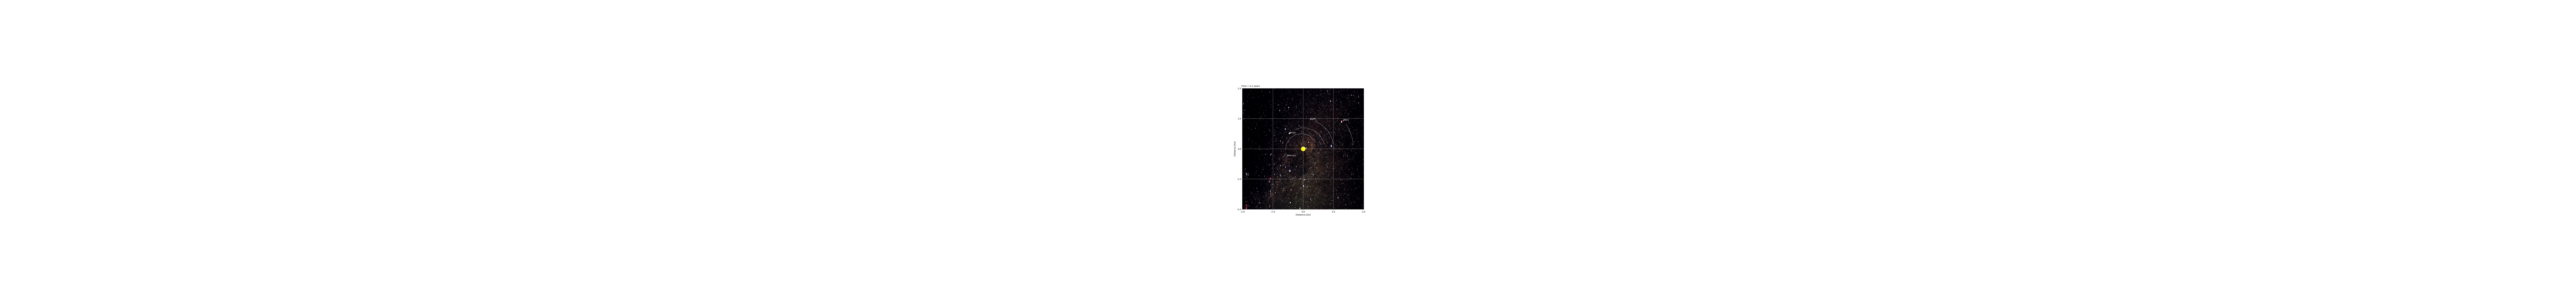

In [148]:
#Animation cell
import warnings
warnings.filterwarnings("ignore")
from time import sleep
from ipywidgets import IntProgress
from IPython.display import display
from PIL import Image
from IPython.display import HTML

'''
    Animation main program, calls routines from upper cell.


    Animation routine:
    
                animate ---> zerosettings ---> update ------>
                                                ^           .
                                                .           .
                                                .increment  .
                                                .zoomer     .
                                                <------------save

 
               Common variables and constants used:
                            
                            input1      (str)      Name of the simulation (1-7)
                            scal        (float)    Scaling parameter of the current width of grid
                            ax,ax2      (obj)      Plotting object
                            myvars      (dict)     Library file of animation objects. In myvars there 
                                                   are 3 different names: "line","point","text".
                                                   Each key has an index, depending on simulation.
                                                   For example, "myvars[text0]" refers to object list
                                                   index 0 (The Sun). Line is the 2d line object, point
                                                   is the point object to be drawn and text is a text
                                                   object.
                            f,count     (int)      Progress bar variables
                            timer       (obj)      Timer object of animation
                            max_count   (int)      Progress bar varible
                            approve     (bool)     Defines if zoomer subroutine is used or not.
                            input_save  (bool)     If true, animation is saved to mp4 - file


'''



print("Animation Progress")
print("..................")
max_count = int(anilength)
f = IntProgress(min=0, max=max_count,description="Loading",bar_style='success') # instantiate the bar
display(f) # display the bar
count = 0
approve = False

i=0
#Set simulation axes,figure etc.
fig, ax= plt.subplots(figsize=(10,10),facecolor='none')
ax.set_aspect('equal')
ax.grid()
scal=zerosettings(input1,ax)
ax.set_xlabel("Distance [AU]")
ax.set_ylabel("Distance [AU]")
ax.patch.set_facecolor('none') # set the facecolor to none
ax.patch.set_alpha(0) 

if input1 != "5":
    img = Image.open('test.png')
else:
    img = Image.open('bh.png')
ax2 = fig.add_subplot(1, 1, 1, facecolor='none')
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(img, extent=[0, 1, 0, 1], aspect='auto', alpha=1)
ax2.set_zorder(-1)

#-----------------------------
my_vars = {}
for i in range(len(l_obj)+1):
    line = "line%d" % i
    point = "point%d" % i
    text = "text%d" % i
    my_vars[line] = i
    my_vars[point] = i
    my_vars[text] = i
    try:
        my_vars["line"+str(i)], = ax.plot([],[],color="white",linestyle = "dashed",lw=1)
        my_vars["point"+str(i)], = ax.plot(l_obj[i].distance[0],l_obj[i].distance[1], 
                                       marker="o", markersize=0.5*l_obj[i].size, 
                                       markeredgecolor="white",markeredgewidth=0.5, markerfacecolor=l_obj[i].color)
        my_vars["text"+str(i)] = ax.text(l_obj[i].distance[0],l_obj[i].distance[1] , l_obj[i].name, color="white")
        
    except:
        #Note! Center of mass is not animated. Uncomment to use it!
        #my_vars["line"+str(i)], = ax.plot([CM.distance[0]],[CM.distance[1]],color="white",lw=1, linestyle = "dashed")
        #my_vars["point"+str(i)], = ax.plot(CM.distance[0],CM.distance[1], 
         #                              marker="o", markersize=CM.size, 
          #                             markeredgecolor="black", markerfacecolor="black")
        #my_vars["text"+str(i)] = ax.text(CM.distance[0],CM.distance[1] , CM.name, color="white")
        continue

#---------ANIMATE----------------------------------------------------------------------------
anim = animation.FuncAnimation(fig,func=a_update,frames=int(anilength),interval=10,blit=True)
#--------END of ANIMATE----------------------------------------------------------------------

#----------Saving---------------------------------------------
input_save = input("Save? (y)")
if input_save == "y" or input_save == "Y":
    writervideo = animation.FFMpegWriter(fps=30)
    anim.save('savefiles/Animation'+input1+'.mp4', writer=writervideo)
    print("Saving finished")
#------------------------------------------------------------
#--------Set the animation to starting settings.-------------
i=0
while i<len(l_obj):
    l_obj[i].distance = l_obj[i].track[-1,:]
    i=i+1
#------------------------------------------------------------
    
print("Animating..")
#Animate it again to screen    
HTML(anim.to_jshtml())

In [121]:
#TODO


#Fix CMO point update.
#DELETE CMO
print(l_obj[2].radius)
print(2*l_obj[2].radius)

1120000000.0
2240000000.0
